<a href="https://colab.research.google.com/github/ydsyvn/Spray-Wall-Boulder-Genration/blob/main/final_project_hold_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<h1 dir="rtl">פרוייקט סיום - סגמנטצית אחיזות טיפוס - עידו סיון</h1>



לקחתי את הנתונים מפה:
[github](https://github.com/mcloses/smear-beta)

כתבה שימושית: [Modify Dataset class for COCO data](https://medium.com/fullstackai/how-to-train-an-object-detector-with-your-own-coco-dataset-in-pytorch-319e7090da5)

In [ ]:
# Import libraries
import numpy as np
import os
import json
from PIL import Image
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.utils import plot_model

from keras.applications.vgg16 import VGG16

In [ ]:
# Mount drive and get dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###<h3> resize images </h3>

In [ ]:
def resize_images(image_dir, output_dir, new_size=(640, 480)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img = Image.open(os.path.join(image_dir, filename))
            img = img.resize(new_size, Image.ANTIALIAS)
            img.save(os.path.join(output_dir, filename))


In [ ]:
resize_images('/content/drive/MyDrive/Data/hold segmentation/segmentation images', '/content/drive/MyDrive/Data/hold segmentation/images')

<ipython-input-5-6ef739708373>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(new_size, Image.ANTIALIAS)


KeyboardInterrupt: 

In [ ]:
# Import COCO API
from pycocotools.coco import COCO

# Initialize COCO API for train and val sets
train_coco = COCO('/content/drive/MyDrive/Data/hold segmentation/train.json')
val_coco = COCO('/content/drive/MyDrive/Data/hold segmentation/test.json')

loading annotations into memory...
Done (t=1.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


In [ ]:
# Load sample image using COCO API
img_id = 1
image = train_coco.loadImgs(img_id)[0]
img_path = os.path.join('/content/drive/MyDrive/Data/hold segmentation/segmentation images', image['file_name'])
img = np.array(Image.open(img_path))


In [ ]:
# Load annotations and get masks for all instances
ann_ids = train_coco.getAnnIds(imgIds=image['id'])
anns = train_coco.loadAnns(ann_ids)
masks = np.zeros([img.shape[0], img.shape[1]])
for ann in anns:
  mask = train_coco.annToMask(ann) * 255
  masks = np.maximum(masks, mask)

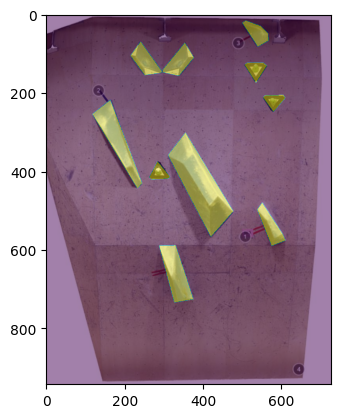

In [ ]:
# Plot image and mask obtained from COCO API
fig, ax = plt.subplots()
ax.imshow(img)
ax.imshow(masks, alpha=0.5)

###<h3> resizt the dataset with the class </h3>

In [ ]:
import os
import torch
from PIL import Image
from torchvision.transforms import functional as F
from pycocotools.coco import COCO

class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotation_file, new_size=(640, 480)):
        self.image_dir = image_dir
        self.new_size = new_size
        self.coco = COCO(annotation_file)
        self.ids = list(self.coco.imgs.keys())

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        # Load the image
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        # Load the masks
        masks = np.zeros([img_info['height'], img_info['width']])
        for ann in anns:
            mask = coco.annToMask(ann) * 255
            masks = np.maximum(masks, mask)
        masks = Image.fromarray(masks)

        # Resize image and masks
        img = F.resize(img, self.new_size)
        masks = F.resize(masks, self.new_size)

        # Convert to PyTorch tensors
        img = F.to_tensor(img)
        masks = torch.from_numpy(np.array(masks)).unsqueeze(0).float()

        return img, masks

    def __len__(self):
        return len(self.ids)


In [ ]:
train_dataset = CocoDataset('/content/drive/MyDrive/Data/hold segmentation/segmentation images', '/content/drive/MyDrive/Data/hold segmentation/train.json')


loading annotations into memory...
Done (t=0.84s)
creating index...
index created!


In [ ]:
val_dataset = CocoDataset('/content/drive/MyDrive/Data/hold segmentation/segmentation images', '/content/drive/MyDrive/Data/hold segmentation/test.json')


loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


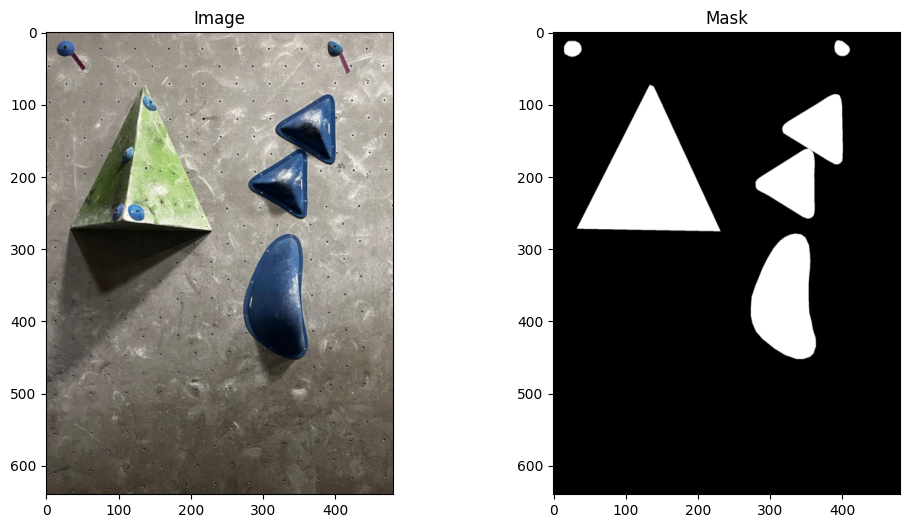

In [ ]:
import random

# Select a random image
index = random.randint(0, len(train_dataset) - 1)
img, mask = train_dataset[index]

# Convert tensors to numpy arrays for visualization
img = img.permute(1, 2, 0).numpy()
mask = mask.squeeze().numpy()

# Plot the image and the mask
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(img)
ax[0].set_title('Image')

ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Mask')

plt.show()

###<h3> transfer learning</h3>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
model = models.segmentation.deeplabv3_resnet50(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:02<00:00, 80.7MB/s]


In [ ]:
num_classes = 2  # replace with the number of classes in your dataset
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))


In [ ]:
model = model.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, masks in train_loader:
        #inputs = inputs.to(device)
        #masks = masks.to(device)

        masks = (masks / 255.0).long()

        optimizer.zero_grad()

        # forward
        outputs = model(inputs)['out']
        loss = criterion(outputs, masks)

        # back
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, masks in val_loader:
            #inputs = inputs.to(device)
            #masks = masks.to(device)

            outputs = model(inputs)['out']
            loss = criterion(outputs, masks)

            val_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    epoch_val_loss = val_loss / len(val_dataset)
    print(f'Epoch {epoch}/{num_epochs - 1}, Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# After training loop
model.eval()
eval_loss, eval_accuracy = evaluate_model(model, testloader, criterion, device)

print(f'Evaluation Loss: {eval_loss}')
print(f'Accuracy: {eval_accuracy}')


In [ ]:

# Plot the training graph
plt.figure(figsize=(10, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Training Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


###<h3> train a model on the resized dataset</h3>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super(SegNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super(SegNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = SegNet().to(device)

In [ ]:
from torchvision import models
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
  ConvTranspose2d-11         [-1, 64, 112, 112]          32,832
             ReLU-12         [-1, 64, 112, 112]               0
  ConvTranspose2d-13         [-1, 32, 224, 224]           8,224
             ReLU-14         [-1, 32, 2

In [ ]:
criterion = nn.BCEWithLogitsLoss()  # nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def calculate_accuracy(preds, targets):
    preds = preds.argmax(dim=1)
    correct = (preds == targets).float()
    acc = correct.sum() / (targets.size(0) * targets.size(1) * targets.size(2))
    return acc


In [ ]:
num_epochs = 10
history = {'loss': [], 'accuracy': []}  # To store the history of losses and accuracies

for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0

    for inputs, masks in train_loader:
        inputs = inputs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        acc = calculate_accuracy(outputs, masks)

        print(loss.item(), inputs.size(0))

        running_loss += loss.item() * inputs.size(0)
        running_acc += acc.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_acc / len(train_dataset)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)


-28.542741775512695 4
-39.8118896484375 4
-28.056888580322266 4
-56.91232681274414 4
-46.75266647338867 4
-49.462642669677734 4
-34.832767486572266 4
-22.176279067993164 4
-19.926923751831055 4
-60.09560012817383 4
-53.55847930908203 4
-38.76544189453125 4
-29.35395622253418 4
-35.30968475341797 4
-24.397775650024414 4
-42.14720153808594 4
-28.194570541381836 4
-50.88072204589844 4
-31.449539184570312 4
-32.14875411987305 4
-41.06757736206055 4
-29.885515213012695 4
-43.799591064453125 4
-28.748828887939453 4
-37.71989059448242 4
-29.735239028930664 4
-52.66423416137695 4
-32.341835021972656 1
Epoch 0/9, Loss: -37.5957, Accuracy: 1018465.0367
-54.17123031616211 4
-46.87080001831055 4
-37.71992492675781 4
-21.785797119140625 4
-39.585533142089844 4
-33.703800201416016 4
-55.69613265991211 4
-34.368919372558594 4
-32.833736419677734 4
-41.29693603515625 4
-30.977924346923828 4
-36.30754470825195 4
-32.66445541381836 4
-33.80281448364258 4
-42.892215728759766 4
-66.9519271850586 4
-38.787

In [ ]:
def predict(model, image):
    # Ensure the model is in evaluation mode
    model.eval()

    # Move the image to the device
    image = image.to(device)

    # Add an extra batch dimension
    image = image.unsqueeze(0)

    # Forward pass
    with torch.no_grad():
        output = model(image)

    # Apply sigmoid and remove batch dimension
    output = torch.sigmoid(output).squeeze(0)

    # Move the output back to CPU and convert to numpy array
    output = output.cpu().numpy()

    return output


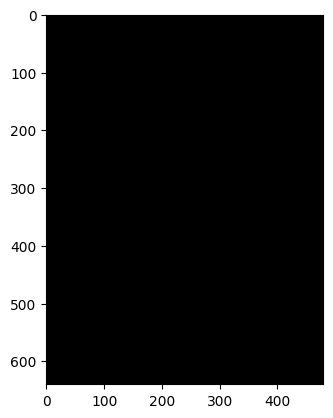

In [ ]:
# Load an image from the dataset
image, _ = train_dataset[0]

# Make a prediction
predicted_mask = predict(model, image)

# Remove the batch dimension for display
predicted_mask = predicted_mask[0]

# Display the predicted mask
plt.imshow(predicted_mask, cmap='gray')
plt.show()

###<h3> pytorch </h3>

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class COCODataset(Dataset):
    def __init__(self, coco, transform=None):
        self.coco = coco
        self.ids = list(coco.imgs.keys())
        self.transform = transform

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        annotations = coco.loadAnns(ann_ids)

        path = '/content/drive/MyDrive/Data/hold segmentation/images/' + coco.loadImgs(img_id)[0]['file_name']
        #print(path)
        image = Image.open(path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        # Convert annotations to tensors, if necessary
        # ...

        return image, annotations

    def __len__(self):
        return len(self.ids)


In [ ]:

from torch.utils.data import DataLoader
from torchvision import transforms

# Define your transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create the datasets
train_dataset = COCODataset(train_coco, transform=transform)
val_dataset = COCODataset(val_coco, transform=transform)

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)


In [ ]:
import torch

import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms


In [ ]:
import torchvision
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:03<00:00, 54.4MB/s]


In [ ]:
num_classes = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Choose an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
n_epochs = 10

# Train the model
for epoch in range(n_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        # Move inputs and targets to the correct device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Print loss for every 10th batch
        if i % 10 == 0:
            print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}")


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 142, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 142, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 138, in collate
    raise RuntimeError('each element in list of batch should be of equal size')
RuntimeError: each element in list of batch should be of equal size


###<h3> keras </h3>

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pycocotools.coco import COCO

In [ ]:
def create_model():
    model = keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(None, None, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same'))
    model.add(layers.Conv2D(1, (1, 1), activation='sigmoid'))

    return model


In [ ]:
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
from skimage.io import imread
from skimage.transform import resize

def data_generator(coco, batch_size=32, img_size=(128, 128)):
    img_ids = coco.getImgIds()
    ann_ids = coco.getAnnIds()
    while True:
        for i in range(0, len(img_ids), batch_size):
            batch_img_ids = img_ids[i:i+batch_size]
            batch_images = []
            batch_masks = []
            for img_id in batch_img_ids:
                img_data = coco.loadImgs(img_id)[0]
                img = imread(img_data['coco_url'])
                print(img_data['coco_url'])
                img = resize(img, img_size)
                mask = coco.annToMask(coco.loadAnns(ann_ids[img_id])[0])
                mask = resize(mask, img_size)
                batch_images.append(img)
                batch_masks.append(mask)
            yield np.array(batch_images), np.array(batch_masks)

In [ ]:
# You need to implement a data generator that yields batches of (image, mask) pairs.
train_data = data_generator(train_coco)
val_data = data_generator(val_coco)

model.fit(train_data, validation_data=val_data, epochs=10)


OSError: Cannot understand given URI: None.

defining the train and val sets: